# Dogs v Cats
A hybrid VGG / ConvNet inspired by Francois' [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)


In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
root_path = "data/dogscats-redux/"

use_small_dataset = False
path = root_path + "sample/" if use_small_dataset else root_path

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (6BE0:00:00.0)
Using Theano backend.


In [5]:
def plot_train_validation_curves(title, training_series, validation_series):
    num_epochs = len(training_series)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, validation_series, label='validation')
    plt.plot(epochs, training_series, label='train')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Begin

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator

## get training and validation data

In [7]:
batch_size = 64
def get_batches_for_vgg(image_dir_path, batch_size):
    generator = ImageDataGenerator()
    return generator.flow_from_directory(image_dir_path, batch_size=batch_size,
                                         class_mode=None,
                                         target_size=(224,224),
                                         shuffle=False)
train_generator = get_batches_for_vgg(path+'train', batch_size=batch_size)
validation_generator = get_batches_for_vgg(path+'validation', batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Use the convolutional parts of Vgg16 to save bottleneck features
Basically, all the convolution and maxpooling leading right up to the concatenation before classification

In [36]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ReduceLROnPlateau

In [9]:
vgg_model = VGG16(weights='imagenet', include_top=False)
bottleneck_train_features = vgg_model.predict_generator(train_generator, val_samples=train_generator.nb_sample)
bottleneck_val_features = vgg_model.predict_generator(validation_generator, val_samples=validation_generator.nb_sample)
np.save(open(path+'bottleneck_features_train.npy', 'w'), bottleneck_train_features)
np.save(open(path+'bottleneck_features_validation.npy', 'w'), bottleneck_val_features)

# Define our small classifier model

# Load the saved bottleneck features from partial VGG

In [10]:
if bottleneck_train_features is None:
    print("loading bottleneck train features from disk")
    bottleneck_train_features = np.load(open('bottleneck_features_train.npy'))
if bottleneck_val_features is None:
    print("loading bottleneck val features from disk")
    bottleneck_val_features = np.load(open('bottleneck_features_validation.npy'))

In [11]:
def num_examples_of(category, dataset_name):
    return len(os.listdir(path + dataset_name + '/' + category))
num_examples_of('cats', 'train')

10000

In [12]:
train_data = bottleneck_train_features
# assumes that the cats were generated first followed by the dogs
# one-hot encoding: cats are label [1,0] and dogs are label [0,1]
train_labels = np.array([[1,0]] * num_examples_of('cats', 'train') + [[0,1]] * num_examples_of('dogs', 'train'))
validation_data = bottleneck_val_features
validation_labels = np.array([[1,0]] * num_examples_of('cats', 'validation') + [[0,1]] * num_examples_of('dogs', 'validation'))

In [13]:
train_data.shape

(20000, 512, 7, 7)

In [14]:
train_labels.shape

(20000, 2)

## now create the classifier model

In [46]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:])) # skip the first (batch) dimension
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## train the model

In [47]:
batch_size = 64
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
hist = model.fit(train_data, train_labels, validation_data=(validation_data, validation_labels), 
                 batch_size=batch_size, 
                 nb_epoch=30, 
                 callbacks=[reduce_lr])
model.save_weights(path+'kl_second_try.h5')

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 2s - loss: 5.6968 - acc: 0.6452 - val_loss: 2.1373 - val_acc: 0.8664
Epoch 2/30
20000/20000 [==============================] - 2s - loss: 1.7343 - acc: 0.8918 - val_loss: 1.2304 - val_acc: 0.9230
Epoch 3/30
20000/20000 [==============================] - 2s - loss: 1.4381 - acc: 0.9103 - val_loss: 0.9457 - val_acc: 0.9410
Epoch 4/30
20000/20000 [==============================] - 2s - loss: 1.2603 - acc: 0.9215 - val_loss: 0.9332 - val_acc: 0.9420
Epoch 5/30
20000/20000 [==============================] - 2s - loss: 1.1388 - acc: 0.9290 - val_loss: 1.2921 - val_acc: 0.9196
Epoch 6/30
20000/20000 [==============================] - 2s - loss: 1.1249 - acc: 0.9301 - val_loss: 0.7804 - val_acc: 0.9514
Epoch 7/30
20000/20000 [==============================] - 2s - loss: 1.0237 - acc: 0.9365 - val_loss: 1.3666 - val_acc: 0.9152
Epoch 8/30
20000/20000 [==============================] - 2s -

## evaluate performance

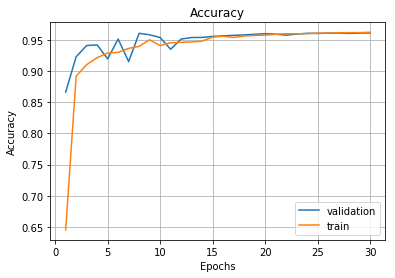

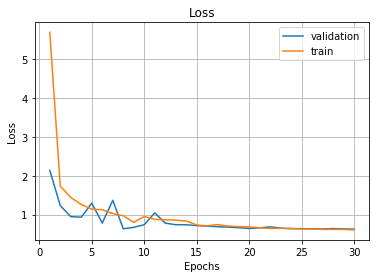

In [48]:
plot_train_validation_curves('Accuracy', hist.history['acc'], hist.history['val_acc'])
plot_train_validation_curves('Loss', hist.history['loss'], hist.history['val_loss'])

## kick the tires

In [44]:
demo_batches = ImageDataGenerator().flow_from_directory(path+'train', batch_size=6,
                                         class_mode='categorical',
                                         target_size=(224,224),
                                         shuffle=True)

Found 20000 images belonging to 2 classes.


[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

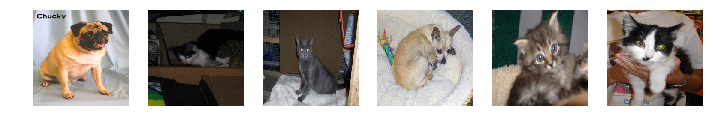

In [45]:
imgs, labels = next(demo_batches)
print(labels)
plots(imgs)
model.predict_on_batch(vgg_model.predict(imgs))

# Kaggle Submission

In [23]:
from keras.preprocessing.image import ImageDataGenerator

def get_test_batches(path, batch_size):
    gen = ImageDataGenerator()
    return gen.flow_from_directory(path, target_size=(224,224), class_mode=None, shuffle=False, batch_size=batch_size)

In [24]:
test_batches = get_test_batches(path + 'test', batch_size=32)

Found 12500 images belonging to 1 classes.


## Predict

run the test data through the VGG model to get the bottlenecked test feature maps
then run them through the classifier model to get the predictions

In [25]:
bottlenecked_test_data = vgg_model.predict_generator(test_batches, test_batches.nb_sample)
np.save(open(path+'bottleneck_features_test.npy', 'w'), bottleneck_train_features)

In [30]:
if bottlenecked_test_data is None:
    print("loading bottleneck test features from disk")
    bottlenecked_test_data = np.load(open('bottleneck_features_test.npy'))

In [26]:
bottlenecked_test_data.shape

(12500, 512, 7, 7)

In [27]:
dog_predictions = model.predict_on_batch(bottlenecked_test_data)[:,1]
dog_predictions[:5]

array([ 0.,  1.,  0.,  1.,  1.], dtype=float32)

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [28]:
ids = [int(x.split("/")[1].split(".")[0]) for x in test_batches.filenames]

fill out the submission table

In [29]:
with open(root_path + 'keith_submission_hybrid_bottleneck.csv', 'w') as f:
    f.write('id,label\n')
    for i in range(len(ids)):
        f.write('{},{}\n'.format(ids[i], dog_predictions[i]))